In [128]:
from beattrack.model import BeatNet
import torchaudio
from torchaudio.transforms import MelSpectrogram
from pathlib import Path
from IPython.display import Audio
import librosa
from einops import rearrange
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from madmom.features import DBNBeatTrackingProcessor

In [129]:
n_fft = 2048
win_length = None
sample_rate = 44100
hop_size = round(sample_rate / 100)  # 10ms hop size
n_mels = 81
window = torch.hann_window(n_fft)
data_length = 30 * sample_rate  # 30 seconds of audio
mel_spec = MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    hop_length=hop_size,
    win_length=win_length,
    n_mels=n_mels,
)
def preprocess(audio_path):
    audio, sr = torchaudio.load(audio_path)
    resample = torchaudio.transforms.Resample(
            orig_freq=sr, new_freq=sample_rate
    )
    audio = resample(audio)
    data_length = 30 * sample_rate  # 30 seconds of audio
    
    # Pad or trim to 30 seconds
    if audio.shape[1] < data_length:
        audio = F.pad(audio, (0, data_length - audio.shape[1]))
    else:
        audio = audio[:, :data_length]
    mel = mel_spec(audio)
    channels, bins, frames = mel.shape
    print(mel.shape)
    mel = rearrange(mel, "c b f -> f (b c)")
    print(mel.shape)
    return mel


In [130]:
model = BeatNet.load_from_checkpoint("checkpoints/epoch=45-valid_loss=0.114.ckpt")
model = model.eval()

dbn = DBNBeatTrackingProcessor(min_bpm=55, max_bpm=215, transition_labmda = 100, fps=100)

In [131]:
files = []
root = Path("data/ballroom_small")
for folder in root.iterdir():
    if folder.is_dir():
        for file in folder.iterdir():
            if file.suffix == ".wav":
                files.append(file)
                break

In [132]:
test = Path("/Users/matthewrice/Developer/QMUL/Music_Informatics/beattrack/data/ballroom_small/ChaChaCha/Media-103816.wav")
mel = preprocess(test)

torch.Size([1, 81, 3001])
torch.Size([3001, 81])


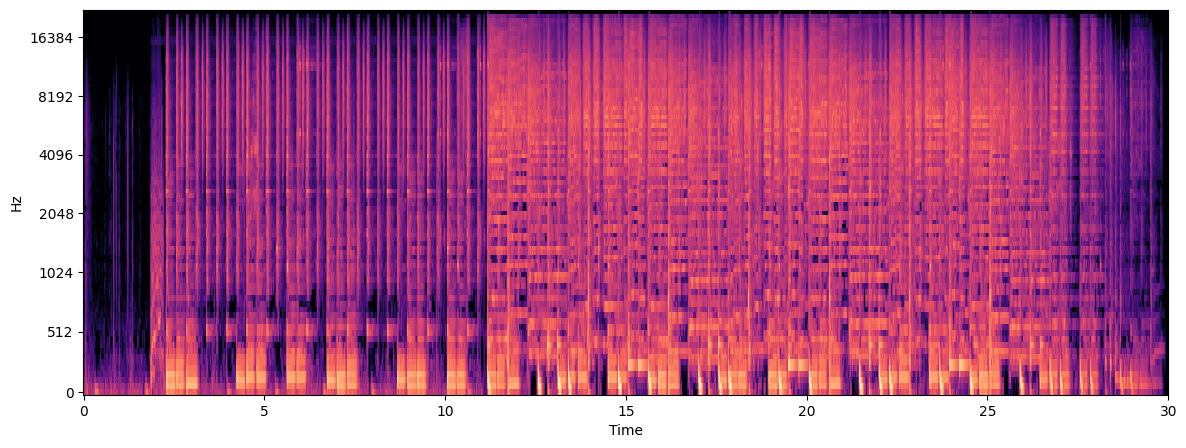

In [133]:
audio, sr = librosa.load(test, sr=sample_rate)
plt.figure(figsize=(14, 5))
S_dB = librosa.power_to_db(mel.T.numpy(), ref=np.max)
librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel", n_fft = n_fft, hop_length=hop_size)
Audio(audio, rate=sr)


In [134]:
mel = mel.unsqueeze(0).unsqueeze(0)
mel.shape

torch.Size([1, 1, 3001, 81])

In [135]:
with torch.no_grad():
    beats = model(mel)
beat_times = dbn(beats.view(-1))

/Users/matthewrice/Developer/QMUL/Music_Informatics/beattrack/env/lib/python3.10/site-packages/madmom/features/beats_hmm.py:565: RuntimeWarning: divide by zero encountered in log
  log_densities[:, 0] = np.log((1. - observations) /
/Users/matthewrice/Developer/QMUL/Music_Informatics/beattrack/env/lib/python3.10/site-packages/madmom/features/beats_hmm.py:567: RuntimeWarning: divide by zero encountered in log
  log_densities[:, 1] = np.log(observations)
/Users/matthewrice/Developer/QMUL/Music_Informatics/beattrack/env/lib/python3.10/site-packages/madmom/features/beats.py:927: RuntimeWarning: -inf log probability during Viterbi decoding cannot find a valid path
  path, _ = self.hmm.viterbi(activations)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [136]:
for beat in beats.view(-1):
    print(beat)

tensor(1.4303e-09)
tensor(1.7812e-13)
tensor(2.2774e-08)
tensor(7.0893e-06)
tensor(4.0072e-05)
tensor(5.1251e-07)
tensor(0.0004)
tensor(4.2255e-05)
tensor(3.1907e-07)
tensor(2.3037e-08)
tensor(5.0286e-08)
tensor(3.7639e-08)
tensor(1.4941e-12)
tensor(3.5048e-13)
tensor(2.1774e-06)
tensor(6.7572e-11)
tensor(4.6452e-13)
tensor(1.6360e-09)
tensor(2.1281e-06)
tensor(2.6730e-06)
tensor(1.4723e-06)
tensor(6.0487e-09)
tensor(4.5009e-09)
tensor(4.2776e-06)
tensor(4.6434e-09)
tensor(2.4895e-13)
tensor(2.8449e-18)
tensor(9.4350e-17)
tensor(7.3300e-18)
tensor(1.7369e-16)
tensor(5.5468e-16)
tensor(1.6084e-06)
tensor(5.6553e-08)
tensor(2.5313e-10)
tensor(2.8504e-10)
tensor(1.2659e-14)
tensor(9.0057e-16)
tensor(1.1352e-19)
tensor(6.2060e-18)
tensor(3.4886e-14)
tensor(3.4888e-14)
tensor(4.9813e-13)
tensor(3.0091e-12)
tensor(3.3848e-11)
tensor(3.3969e-09)
tensor(2.1550e-06)
tensor(2.2564e-07)
tensor(2.6232e-06)
tensor(8.4789e-05)
tensor(9.6263e-06)
tensor(6.0514e-13)
tensor(2.5938e-08)
tensor(1.6646e-0

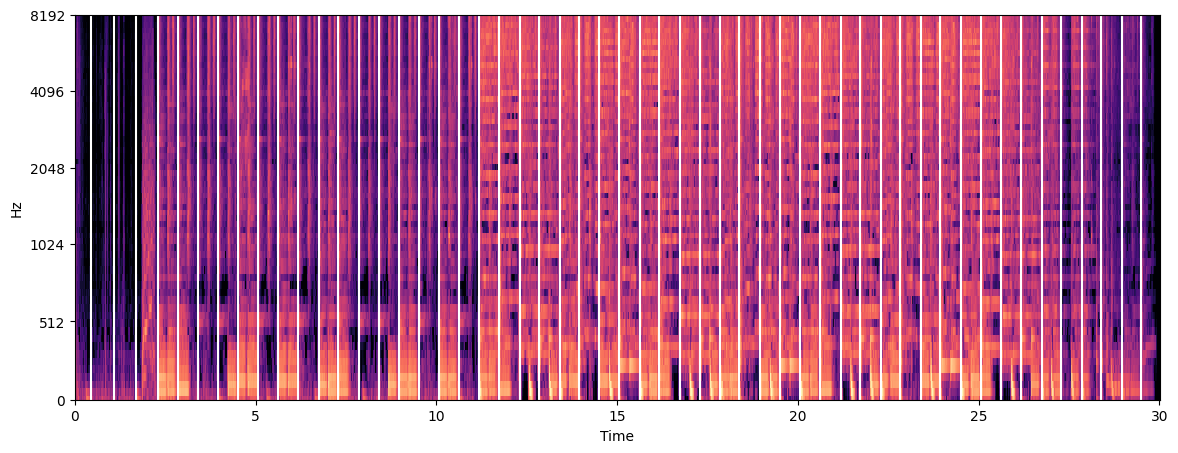

In [137]:
play_clicks = True
plt.figure(figsize=(14, 5))
librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel", n_fft = n_fft, hop_length=hop_size)
plt.vlines(beat_times, 0, 8192, color='w')
plt.ylim(0, 8192)

clicks = librosa.clicks(times = beat_times, sr=sr, length=len(audio))
output = audio
if play_clicks:
    output = audio + clicks
Audio(output, rate=sr)

In [82]:
len(beat_times), beat_times[:5]

(91, array([0.  , 0.32, 0.65, 0.98, 1.31]))

In [83]:
def label2vec(label_file: Path, hop_size: int, num_frames: int) -> torch.Tensor:
    labels = [0] * num_frames
    for line in label_file.open("r"):
        time, beat_num = line.split(" ")
        frame_id = round(float(time) * sample_rate / hop_size)
        if frame_id < num_frames:
            labels[frame_id] = 1
    return torch.tensor(labels)
label_root = root / "beats"
label_file = label_root / f"{test.stem}.beats"
label = label2vec(label_file, hop_size, mel.shape[2])
loss = F.binary_cross_entropy(beats.squeeze(1), label.view(1, -1).float())
print(loss)

tensor(0.1195)


In [84]:
outputs = []
for i, lab in enumerate(label):
    if lab == 1:
        outputs.append(i * hop_size / sample_rate)

In [93]:
outputs

[0.36,
 0.85,
 1.34,
 1.82,
 2.31,
 2.8,
 3.28,
 3.76,
 4.24,
 4.72,
 5.2,
 5.68,
 6.17,
 6.65,
 7.14,
 7.62,
 8.11,
 8.6,
 9.08,
 9.57,
 10.05,
 10.53,
 11.02,
 11.5,
 11.99,
 12.47,
 12.95,
 13.44,
 13.92,
 14.41,
 14.89,
 15.37,
 15.86,
 16.34,
 16.82,
 17.3,
 17.79,
 18.27,
 18.76,
 19.24,
 19.73,
 20.21,
 20.69,
 21.17,
 21.65,
 22.13,
 22.62,
 23.1,
 23.59,
 24.07,
 24.56,
 25.04,
 25.53,
 26.01,
 26.5,
 26.98,
 27.47,
 27.95,
 28.44,
 28.92,
 29.41,
 29.89]